In [1]:
import numpy as np
import pandas as pd

# Step 1. Feature Extraction

In [2]:
# get thread_data from csv files 
import os
import string

folder_path = '/Users/lily/Desktop/data_output/'
all_files = os.listdir(folder_path)
thread_data = pd.DataFrame()
for file_name in all_files:
    doc_df = pd.read_csv(folder_path+file_name, encoding=('iso-8859-1'))
    thread_data = thread_data.append(doc_df, ignore_index= True)
    
thread_data['Message Bodies'] = [w.replace('\\xa0', ' ').replace('\\n', ' ') for w in thread_data['Message Bodies']]

#also remove all punctuation
translator = str.maketrans('', '', string.punctuation)
thread_data['Message Bodies'] = [s.translate(translator) for s in thread_data['Message Bodies']]

# export data to csv file
thread_data.to_csv('data_original.csv', encoding='utf-8', index=False)

## Extract thread based features

In [3]:
from bs4 import BeautifulSoup
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sid = SentimentIntensityAnalyzer()


for i in range(len(thread_data)):
    # do counts
    Message_soup = BeautifulSoup(thread_data['Message HTML'][i], 'html.parser')
    thread_data.loc[i, 'img_count'] = len(Message_soup.find_all('img')) - len(Message_soup.find_all('img', class_='emoticon'))  # count image tags
    thread_data.loc[i, 'p_count'] = len(Message_soup.find_all('p'))    # count p tags
    thread_data.loc[i, 'word_count'] = len(Message_soup.get_text().split(' ')) # count words
    
    # get sentiment
    ss = sid.polarity_scores(thread_data['Message Bodies'][i])
    
    thread_data.loc[i, 'compound'] = ss['compound']
    thread_data.loc[i, 'neg'] = ss['neg']
    thread_data.loc[i, 'neu'] = ss['neu']
    thread_data.loc[i, 'pos'] = ss['pos']
    
    thread_data.loc[i, 'user_count'] = len(thread_data['User List'][i].split(','))


In [4]:
# export data to csv file
thread_data = thread_data.drop(columns=['Thread ID', 'Message List', 'User List', 'Message HTML', 'Post Times'])
thread_data['Solution Count'] = [0 if x==0 else 1 for x in thread_data['Solution Count']]  
thread_data.to_csv('data.csv', encoding='utf-8', index=False)

## Extract content based features

In [5]:
from scipy.sparse import csr_matrix
from scipy.sparse import hstack
from collections import Counter
from nltk.tokenize.moses import MosesTokenizer
from nltk import word_tokenize
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer 
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

n_features = 2000
mosesTokenizer = MosesTokenizer()
stop_words = set(stopwords.words('english'))
more_stop_words = [',','&quot;','(',')','/','&apos;t','&apos;re','&apos;s','&apos;ve','&gt;','+','~','-','*','\\',':','--', '\'',
                   '#','$','%','&amp;','&apos;','&apos;d','&apos;ll','&apos;m','..','...','....','"']
punct_stop_words = ['?','.']
all_stop_words = stop_words.union(more_stop_words)
all_stop_words_punct = all_stop_words.union(punct_stop_words)


In [6]:
class LemmaTokenizer(object):
     def __init__(self):
         self.wnl = WordNetLemmatizer()
     def __call__(self, doc):
        #Part-Of-Speech Tagged and Word Tokenized 
        tagged = pos_tag((word_tokenize(doc)))
        lems = []

        #For each tagged word, lemmatize the nouns, verbs, and adjectives
        for w,t in tagged:

            #temporay variable to potentially change the word
            l = w 
            #noun
            if(t[0] == 'N'):
                l = self.wnl.lemmatize(w, 'n')
            #verb
            elif(t[0] == 'V'):
                l = self.wnl.lemmatize(w, 'v')
            #adjective    
            elif(t[0] == 'J'):
                l = self.wnl.lemmatize(w, 'a')
    
            lems.append(l)    

        #return list of lemmed words
        return lems

In [11]:
# prepare data
from sklearn.model_selection import train_test_split

thread_df = pd.read_csv('data.csv', encoding='utf-8')

# separate features and targets
thread_X = thread_df.drop(columns=['Solution Count'])
thread_y = [0 if x==0 else 1 for x in thread_df['Solution Count']]  


X_train, X_test, y_train, y_test = train_test_split(thread_X, 
                                                    thread_y, 
                                                    random_state=42, 
                                                    train_size=.7, 
                                                    test_size=.3)

X_train_features = X_train.drop(columns=['Message Bodies'])
X_test_features = X_test.drop(columns=['Message Bodies'])

X_train_csr = csr_matrix(X_train_features.values.astype(int))
X_test_csr = csr_matrix(X_test_features.values.astype(int))


### Extract tf-idf features

In [12]:
print("Extracting tf-idf features...")
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2,
                                   max_features=n_features,
                                   strip_accents = 'unicode',
                                   tokenizer = LemmaTokenizer(),
                                   ngram_range = (1,3),
                                   stop_words=all_stop_words_punct)

tfidf_train = tfidf_vectorizer.fit_transform(X_train['Message Bodies'])
tfidf_test = tfidf_vectorizer.transform(X_test['Message Bodies'])

X_train_tfidf = hstack((X_train_csr, tfidf_train))
X_test_tfidf = hstack((X_test_csr, tfidf_test))

# print tfidf features
tfidf_feature_names = tfidf_vectorizer.get_feature_names()
print (tfidf_feature_names)

Extracting tf-idf features...
['0', '0 1', '00', '01', '1', '1 2', '10', '100', '1000', '100ms', '11', '12', '13', '14', '15', '16', '17', '1d', '1d array', '1khz', '1st', '2', '2 3', '20', '200', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '24', '25', '2d', '2d array', '2nd', '3', '30', '32', '32 bit', '32bit', '3d', '3rd', '4', '40', '5', '50', '500', '6', '60', '64', '64 bit', '64bit', '7', '8', '80', '9', 'ability', 'able', 'able find', 'able get', 'able use', 'abort', 'absolute', 'absolutely', 'accelerometer', 'accept', 'access', 'accomplish', 'accord', 'account', 'accurate', 'achieve', 'acquire', 'acquire data', 'acquisition', 'across', 'act', 'action', 'action engine', 'activate', 'active', 'activex', 'actor', 'actual', 'actually', 'adapter', 'adc', 'add', 'addition', 'additional', 'additionally', 'address', 'adjust', 'advance', 'advanced', 'advantage', 'advice', 'advise', 'affect', 'agilent', 'ago', 'agree', 'ai', 'algorithm', 'allocate', 'allocation

### Extract tf features

In [13]:
print("Extracting tf features...")
tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2,
                                max_features=n_features,
                                strip_accents = 'unicode',
                                tokenizer = LemmaTokenizer(),
                                ngram_range = (1,3),
                                stop_words=all_stop_words_punct)

tf_train = tf_vectorizer.fit_transform(X_train['Message Bodies'])
tf_test = tf_vectorizer.transform(X_test['Message Bodies'])

X_train_tf = hstack((X_train_csr, tf_train))
X_test_tf = hstack((X_test_csr, tf_test))

# print tfidf features
tf_feature_names = tf_vectorizer.get_feature_names()
print (tf_feature_names)

Extracting tf features...
['0', '0 1', '00', '01', '1', '1 2', '10', '100', '1000', '100ms', '11', '12', '13', '14', '15', '16', '17', '1d', '1d array', '1khz', '1st', '2', '2 3', '20', '200', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '24', '25', '2d', '2d array', '2nd', '3', '30', '32', '32 bit', '32bit', '3d', '3rd', '4', '40', '5', '50', '500', '6', '60', '64', '64 bit', '64bit', '7', '8', '80', '9', 'ability', 'able', 'able find', 'able get', 'able use', 'abort', 'absolute', 'absolutely', 'accelerometer', 'accept', 'access', 'accomplish', 'accord', 'account', 'accurate', 'achieve', 'acquire', 'acquire data', 'acquisition', 'across', 'act', 'action', 'action engine', 'activate', 'active', 'activex', 'actor', 'actual', 'actually', 'adapter', 'adc', 'add', 'addition', 'additional', 'additionally', 'address', 'adjust', 'advance', 'advanced', 'advantage', 'advice', 'advise', 'affect', 'agilent', 'ago', 'agree', 'ai', 'algorithm', 'allocate', 'allocation', '

In [42]:
# Feature Name
featureNames_base = X_train_features.columns

# Feature Name tfidf
tfidf_names = pd.Index(tfidf_feature_names)
featureNames_tfidf = featureNames_base.append(tfidf_names)

# Feature Name tf
tf_names = pd.Index(tf_feature_names)
featureNames_tf = featureNames_base.append(tf_names)

# Step 2. Data Pre-Processing

In [14]:
# undersample data
from imblearn.under_sampling import RandomUnderSampler 

def undersample(X_train, y_train):
    rus = RandomUnderSampler(random_state=42)
    X_train_res, y_train_res = rus.fit_sample(X_train, y_train)
        
    return X_train_res, y_train_res

In [15]:
# standard scale data
from sklearn.preprocessing import StandardScaler

def standardscale(X_train, X_test):
    # transform scale of data
    ss = StandardScaler(with_mean=False)
    X_train_scaled = ss.fit_transform(X_train)
    X_test_scaled = ss.transform(X_test)
    return X_train_scaled, X_test_scaled

# Step 3. Model Training

In [40]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

def train(X_train, X_test, y_train, y_test, featureName):

    # set up models
    rf = RandomForestClassifier(random_state = 42)
    svm = SVC(random_state = 42)
    mlp = MLPClassifier(random_state = 42)

    models = [('Random Forest', rf), 
          ('Support Vector Machine', svm),
          ('Neural Networks', mlp)]

    performance = {'Model': [], 'Accuracy': [], 'Precision': [], 'Recall': []}

    for model_name, cur_model in models:
        cur_model.fit(X_train, y_train)
        y_predicted = cur_model.predict(X_test)
        
        accuracy = accuracy_score(y_predicted, y_test)
        precision = precision_score(y_predicted, y_test)
        recall = recall_score(y_predicted, y_test)
        
        performance['Model'].append(model_name)
        performance['Accuracy'].append(accuracy)
        performance['Precision'].append(precision)
        performance['Recall'].append(recall)
        
        # show confusion matrix
        mat = confusion_matrix(y_test, y_predicted)
        sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
        plt.title(model_name)
        plt.xlabel('true label')
        plt.ylabel('predicted label')
        plt.show()
        
    # visualize the feature importance

    clf = rf
    importances = clf.feature_importances_
    indices = np.argsort(importances)[::-1]

    # Plot the feature importances of the forest
    plt.figure()
    plt.title("Feature importances")
    plt.bar(range(X_train.shape[1]), importances[indices],
           color="#5596E6")
    plt.xticks(range(X_train.shape[1]), featureName[indices], rotation=90)
        
    plt.xlim([-0.75, 10.5])
    plt.show()

    return (performance)

## Baseline

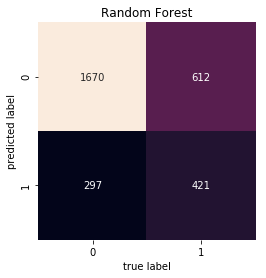

/usr/local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


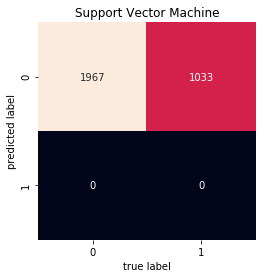

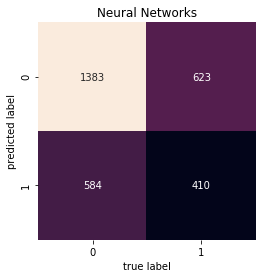

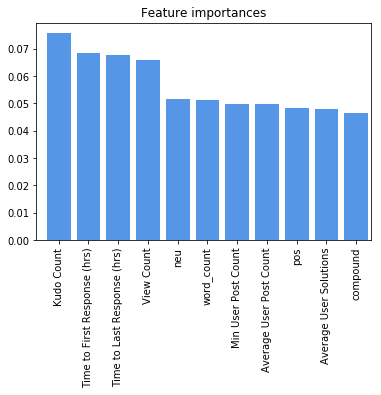

,Accuracy,Precision,Recall
Random Forest,0.697000,0.407551,0.586351
Support Vector Machine,0.655667,0.000000,0.000000
Neural Networks,0.597667,0.396902,0.412475


In [44]:
# baseline
performance = train(X_train_features, X_test_features, y_train, y_test, featureNames_base)
df = pd.DataFrame(performance, index=performance['Model'], columns = ['Accuracy', 'Precision', 'Recall'])
df

## Experiment One

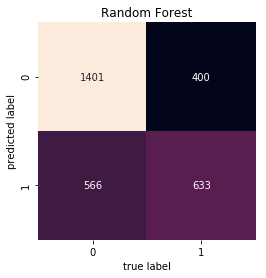

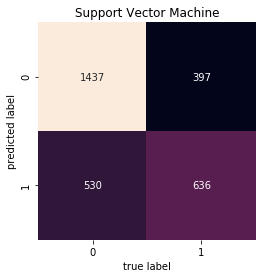

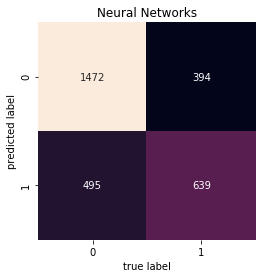

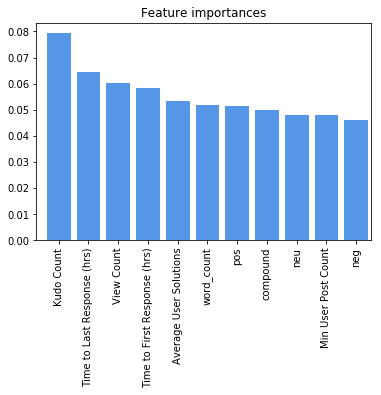

,Accuracy,Precision,Recall
Random Forest,0.678000,0.612778,0.527940
Support Vector Machine,0.691000,0.615682,0.545455
Neural Networks,0.703667,0.618587,0.563492


In [45]:
# baseline + preprocessing
from sklearn.metrics import accuracy_score
from sklearn import metrics

# undersample data
X_train_res, y_train_res = undersample(X_train_features, y_train)

# transform data
X_train_ss, X_test_ss = standardscale(X_train_res, X_test_features)

performance = train(X_train_ss, X_test_ss, y_train_res, y_test, featureNames_base)
df = pd.DataFrame(performance, index=performance['Model'], columns = ['Accuracy', 'Precision', 'Recall'])
df

## Experiment Two

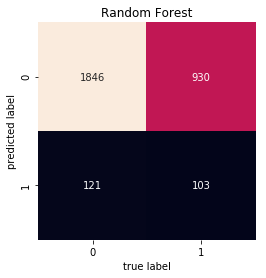

/usr/local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


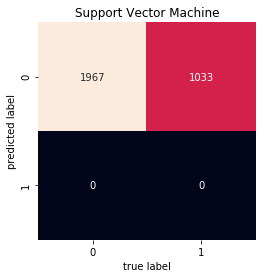

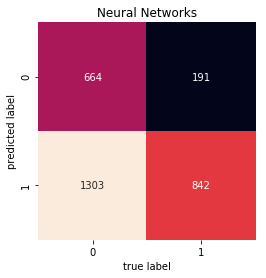

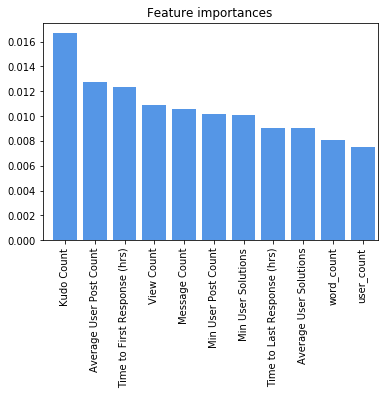

,Accuracy,Precision,Recall
Random Forest,0.649667,0.099710,0.459821
Support Vector Machine,0.655667,0.000000,0.000000
Neural Networks,0.502000,0.815102,0.392541


In [70]:
# experiment one + tf
performance = train(X_train_tf, X_test_tf, y_train, y_test, featureNames_tf)
df = pd.DataFrame(performance, index=performance['Model'], columns = ['Accuracy', 'Precision', 'Recall'])
df

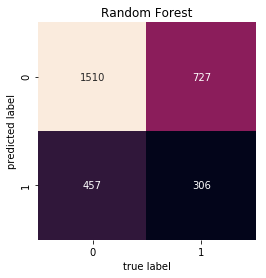

/usr/local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


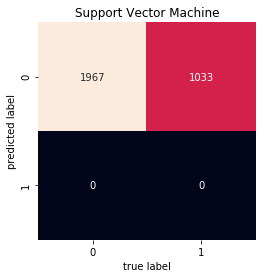

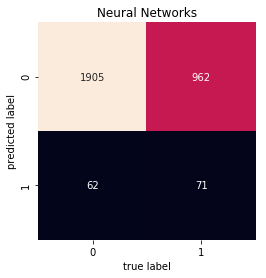

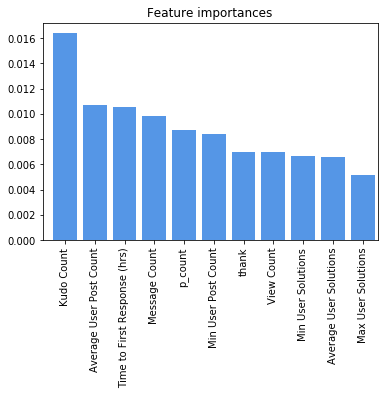

,Accuracy,Precision,Recall
Random Forest,0.605333,0.296225,0.401048
Support Vector Machine,0.655667,0.000000,0.000000
Neural Networks,0.658667,0.068732,0.533835


In [78]:
# experiment one + tfidf
performance = train(X_train_tfidf, X_test_tfidf, y_train, y_test, featureNames_tfidf)
df = pd.DataFrame(performance, index=performance['Model'], columns = ['Accuracy', 'Precision', 'Recall'])
df

## Experiment Three

/usr/local/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


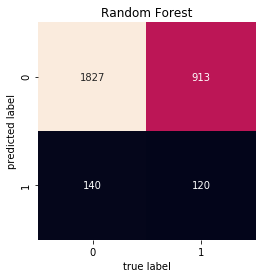

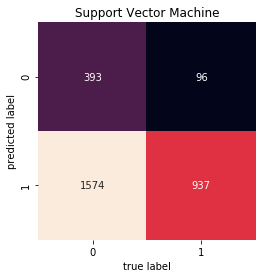

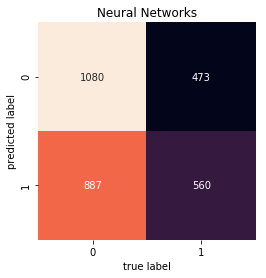

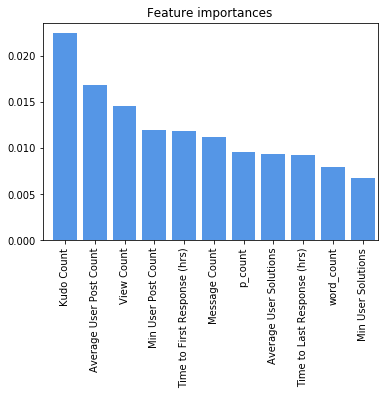

,Accuracy,Precision,Recall
Random Forest,0.649000,0.116167,0.461538
Support Vector Machine,0.443333,0.907067,0.373158
Neural Networks,0.546667,0.542110,0.387008


In [80]:
# experiment one  + tf + scale

# undersample data
X_train_res, y_train_tf = undersample(X_train_tf, y_train)

# transform data
X_train_tf_ss, X_test_tf_ss = standardscale(X_train_res, X_test_tf)

performance = train(X_train_tf_ss, X_test_tf_ss, y_train_tf, y_test, featureNames_tf)
df = pd.DataFrame(performance, index=performance['Model'], columns = ['Accuracy', 'Precision', 'Recall'])
df

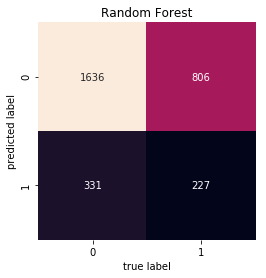

/usr/local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


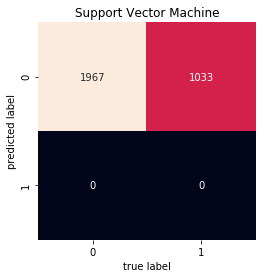

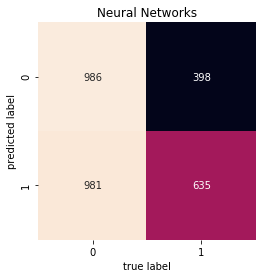

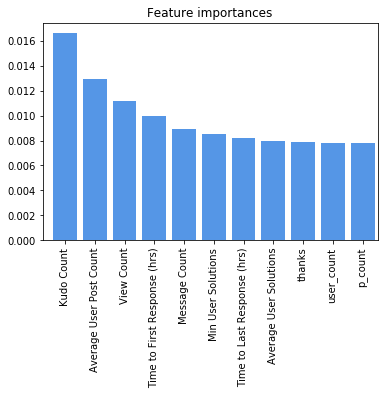

,Accuracy,Precision,Recall
Random Forest,0.621000,0.219748,0.406810
Support Vector Machine,0.655667,0.000000,0.000000
Neural Networks,0.540333,0.614714,0.392946


In [81]:
# experiment one  + tf-idf + scale

# undersample data
X_train_res, y_train_res = undersample(X_train_tfidf, y_train)

# transform data
X_train_tfidf_ss, X_test_tfidf_ss = standardscale(X_train_res, X_test_tfidf)

performance = train(X_train_tfidf_ss, X_test_tfidf_ss, y_train_res, y_test, featureNames_tfidf)
df = pd.DataFrame(performance, index=performance['Model'], columns = ['Accuracy', 'Precision', 'Recall'])
df